#  Crop Disease Detection 

###  Project Summary

In this project, we aim to build a machine learning model that can detect **crop diseases** based on leaf data using the PlantVillage dataset. Early detection of plant diseases is crucial to protecting food security, reducing yield loss, and helping farmers take timely action.

We'll use structured data or image-based data to **classify whether a plant is healthy or infected**, and if infected, determine the specific disease.

---

###  Problem Statement

Farmers often struggle to diagnose plant diseases due to limited access to experts or technology. Automating disease detection can:

- Help farmers **identify diseases early**
- Reduce crop loss
- Improve treatment decision-making
- Enable **mobile-based advisory tools**

Our goal is to develop a **supervised learning model** that can predict the type of disease affecting a plant leaf, using the provided features (image or tabular).

---

###  Project Objectives

1. Load and explore the PlantVillage dataset
2. Clean and preprocess the data
3. Train classification models to detect crop diseases
4. Evaluate model performance using appropriate metrics
5. Use model interpretability tools to explain predictions
6. Provide recommendations based on prediction results

---

###  Dataset Overview

We will use the [PlantVillage dataset](https://www.kaggle.com/datasets/emmarex/plantdisease), which includes:

- **Images** or structured features of plant leaves
- Labels like `"Tomato___Late_blight"`, `"Apple___Black_rot"`, etc.
- Data for multiple crop types and disease classes

The dataset supports both **image classification** and **structured learning**, depending on the format.

---

###  Tools and Technologies

- Python 
- Pandas, NumPy for data handling
- Scikit-learn for modeling
- Matplotlib & Seaborn for visualization
- TensorFlow/Keras for image classification
- SHAP/LIME for model explainability

---

###  Target Audience

This model can benefit:
- Farmers using digital advisory tools
- Agritech companies building mobile apps
- Agricultural researchers and extension officers


---

##  Step 1: Load and Prepare Image Data for Modeling

We are using the image folder version of the PlantVillage dataset. In this step, we'll:

- Load images from directories using Keras
- Automatically assign labels based on folder names (e.g. `Tomato___Early_blight`)
- Resize and normalize image pixels
- Split data into training and validation sets

The images will be rescaled to have pixel values between 0 and 1, and resized to 128x128 for faster training.

In [221]:
import os

# Path to our dataset
dataset_path = r'C:\Users\USER\Documents\Flatiron\Phase 4 project\Crop-Disease-Detection\data\raw\PlantVillage'

In [222]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Image size and batch size
image_size = (256, 256)
batch_size = 32

# Create image data generator with validation split
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training data
train_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Load validation data
val_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

Found 33027 images belonging to 16 classes.
Found 8249 images belonging to 16 classes.


---

##  Step 2: Data Cleaning and Exploratory Data Analysis (EDA)

Even with image data, it's important to explore and understand the dataset before modeling.

We'll:
- Visualize the class distribution
- Preview sample images per disease
- Confirm image shape and rescaling
- Ensure labels match image folders

### **2.1 Check Class Distribution**

It's important to understand how balanced or imbalanced the dataset is across different disease categories.

If certain classes have significantly more or fewer images, the model may become biased, learning to favor more common diseases while ignoring rare ones.

We use the `train_generator` from Keras to extract the class labels and visualize the number of training images per class.

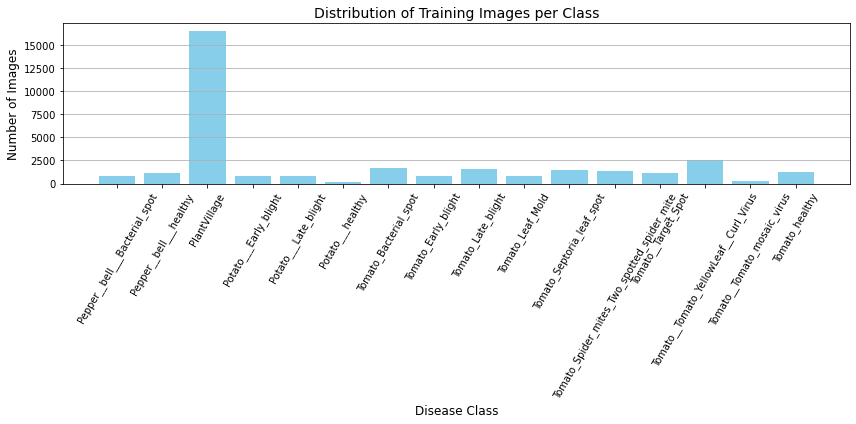

In [223]:
import matplotlib.pyplot as plt
import numpy as np

# Extract class labels and counts
class_labels = list(train_generator.class_indices.keys())
class_counts = [np.sum(train_generator.classes == i) for i in range(len(class_labels))]

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(class_labels, class_counts, color='skyblue')
plt.title("Distribution of Training Images per Class", fontsize=14)
plt.xlabel("Disease Class", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=60)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

The chart above shows the number of training images per class in the PlantVillage dataset.

We observe a significant **class imbalance**, with one class (`PlantVillage`) dominating the dataset, possibly due to a mislabel or directory issue.

Imbalance like this can lead to biased model predictions. We may address it using:
- Class weights
- Data augmentation
- Folder restructuring if needed

This insight helps guide better modeling decisions.

### **2.2 Visualizing Sample Images by Class**

As part of our image dataset EDA, it's important to visually inspect a few examples from different classes. This allows us to:

- Verify that labels are accurate and images are clear
- Understand intra-class variability (how similar images of the same class are)
- Understand inter-class differences (how distinct the classes look visually)

Below we show randomly selected samples from the training set across multiple classes.

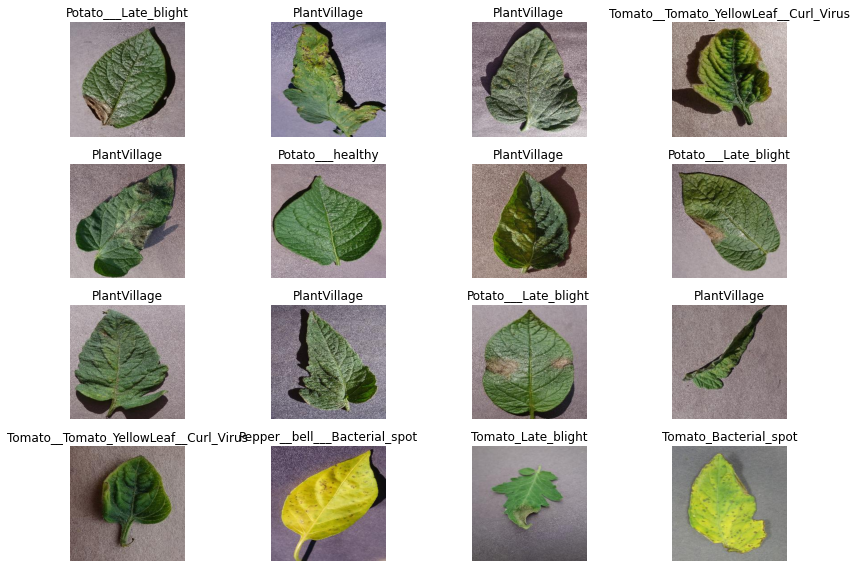

In [224]:
# Take a batch of training images
images, labels = next(train_generator)

# Get class label names
class_labels = list(train_generator.class_indices.keys())

# Plot at least 16 sample images
plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()


Below is a preview of sample images from the training dataset across various classes.

Observations:
- Many images are labeled as **"PlantVillage"**, which is likely an incorrect or root folder label.
- Other images show clear disease patterns like **"Tomato_YellowLeaf_Curl_Virus"**, **"Potato_Late_blight"**, etc.
- Leaf shape, color, and texture vary significantly across diseases — important for model learning.

Recommendation: Fix the dataset folder structure to remove the "PlantVillage" label and ensure each image is categorized correctly.

This visual inspection helps verify label quality and dataset readiness before training the model.

---


In [225]:
dataset_path = r"C:\Users\USER\Documents\Flatiron\Phase 4 project\Crop-Disease-Detection\data\clean\PlantVillage_Cleaned"

#### **2.1.1 Check Cleaned Class Distribution**

In [226]:
# Checking for Misleading or Inconsistent Class Names**
class_names = os.listdir(dataset_path)
print("Class labels:")
for name in sorted(class_names):
    print(f"- {name}")

Class labels:
- Pepper__bell___Bacterial_spot
- Pepper__bell___healthy
- Potato___Early_blight
- Potato___Late_blight
- Potato___healthy
- Tomato_Bacterial_spot
- Tomato_Early_blight
- Tomato_Late_blight
- Tomato_Leaf_Mold
- Tomato_Septoria_leaf_spot
- Tomato_Spider_mites_Two_spotted_spider_mite
- Tomato__Target_Spot
- Tomato__Tomato_YellowLeaf__Curl_Virus
- Tomato__Tomato_mosaic_virus
- Tomato_healthy


In [227]:
# Checking for the Very Small or Empty Classes (Data Imbalance)
from collections import defaultdict
class_counts = defaultdict(int)

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    if os.path.isdir(cls_path):
        class_counts[cls] = len(os.listdir(cls_path))

# Sort and display
sorted_counts = sorted(class_counts.items(), key=lambda x: x[1])
print("Image counts per class (ascending):")
for cls, count in sorted_counts:
    print(f"{cls}: {count} images")

Image counts per class (ascending):
Potato___healthy: 112 images
Tomato__Tomato_mosaic_virus: 273 images
Tomato_Leaf_Mold: 695 images
Pepper__bell___Bacterial_spot: 729 images
Potato___Early_blight: 729 images
Potato___Late_blight: 729 images
Tomato_Early_blight: 729 images
Tomato__Target_Spot: 1025 images
Pepper__bell___healthy: 1078 images
Tomato_healthy: 1161 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1224 images
Tomato_Septoria_leaf_spot: 1292 images
Tomato_Late_blight: 1393 images
Tomato_Bacterial_spot: 1552 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 2340 images


In [228]:
# Checking the File Extensions (Unexpected Formats)
extensions = Counter()

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    for file in os.listdir(cls_path):
        ext = os.path.splitext(file)[-1].lower()
        extensions[ext] += 1

print("File extensions found:")
print(extensions)

File extensions found:
Counter({'.jpg': 15061})


In [229]:
# File extensions to remove
invalid_extensions = ['.png', '.jpeg']

removed_files = []

# Traverse all folders and files
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in invalid_extensions:
            full_path = os.path.join(root, file)
            try:
                os.remove(full_path)
                removed_files.append(full_path)
            except Exception as e:
                print(f"Could not delete: {full_path} | Reason: {e}")

print(f"✅ Removed {len(removed_files)} files with invalid extensions.")

✅ Removed 0 files with invalid extensions.


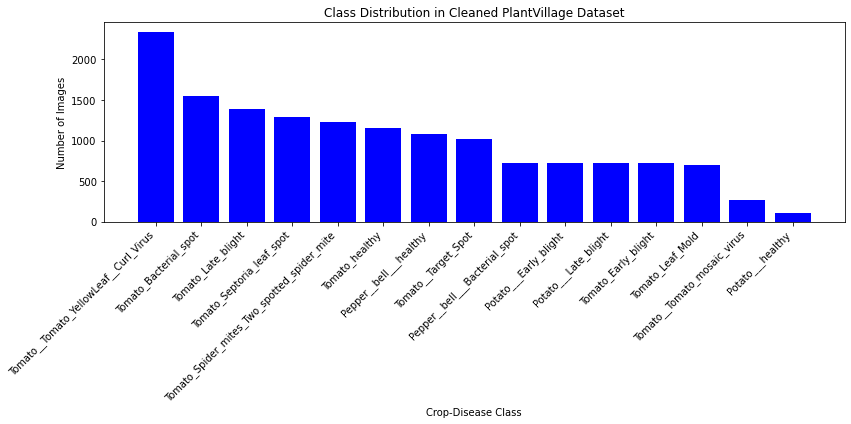

In [230]:
# Count images per class
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        count = len(os.listdir(class_folder))
        class_counts[class_name] = count

# Sort class counts (optional for better visuals)
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution in Cleaned PlantVillage Dataset")
plt.xlabel("Crop-Disease Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show();


This bar chart displays the number of images in each crop-disease class in the cleaned PlantVillage dataset. This helps us visually detect **class imbalance**, which may influence the performance of our classification model. If a few classes dominate, techniques such as class weighting or data augmentation might be needed.


#### **2.2.1 Sample Images per Class**

Pepper__bell___Bacterial_spot: 5 samples


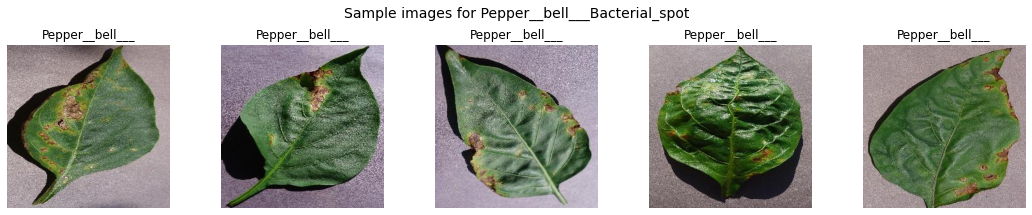

Pepper__bell___healthy: 5 samples


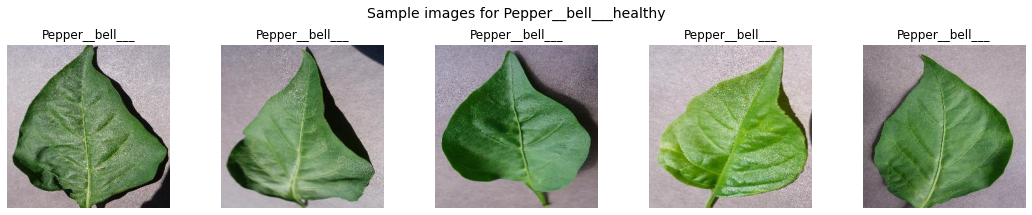

Potato___Early_blight: 5 samples


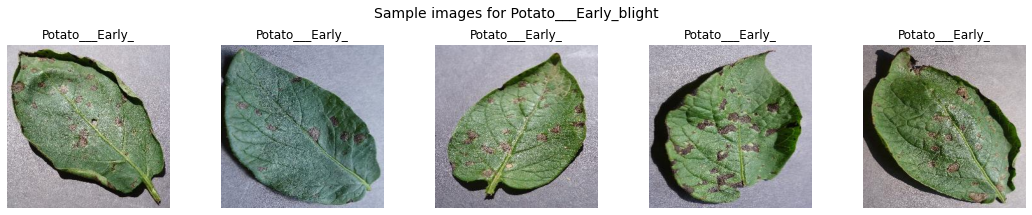

Potato___healthy: 5 samples


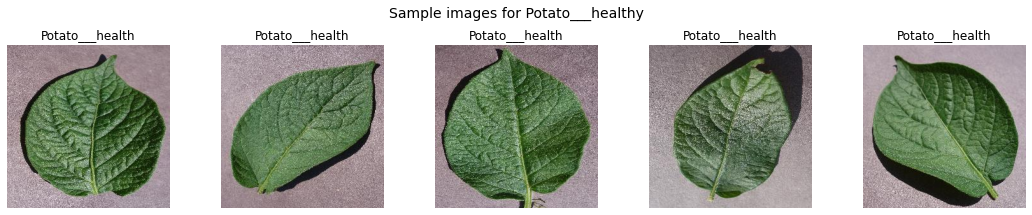

Potato___Late_blight: 5 samples


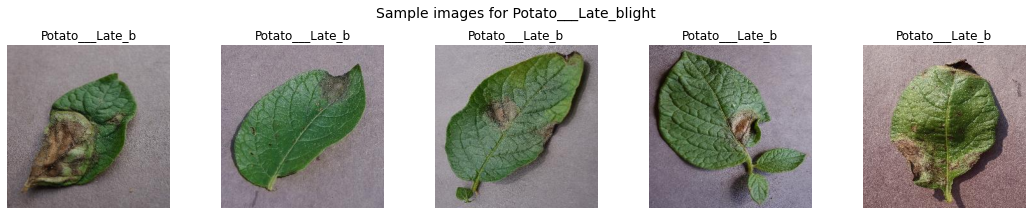

Tomato_Bacterial_spot: 5 samples


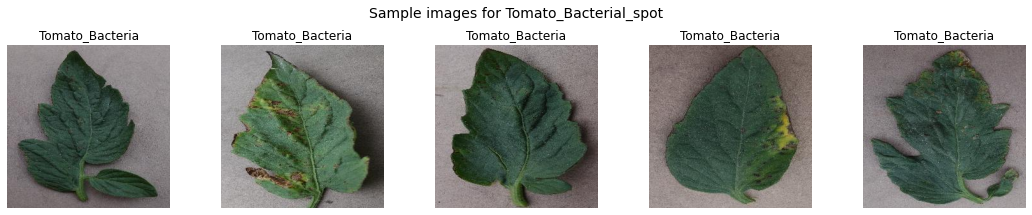

Tomato_Early_blight: 5 samples


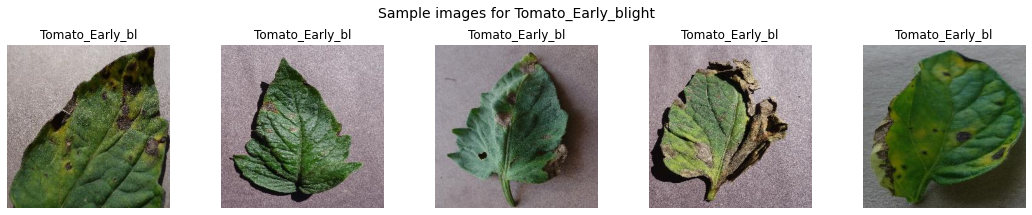

Tomato_healthy: 5 samples


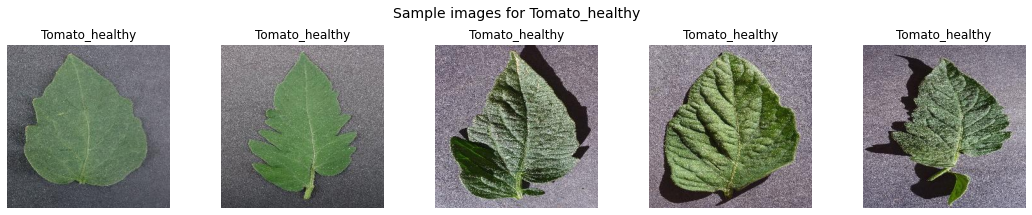

Tomato_Late_blight: 5 samples


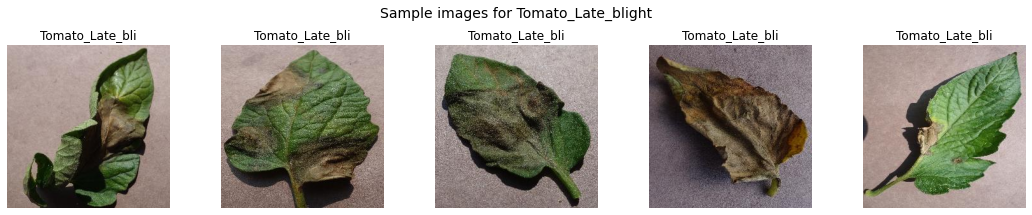

Tomato_Leaf_Mold: 5 samples


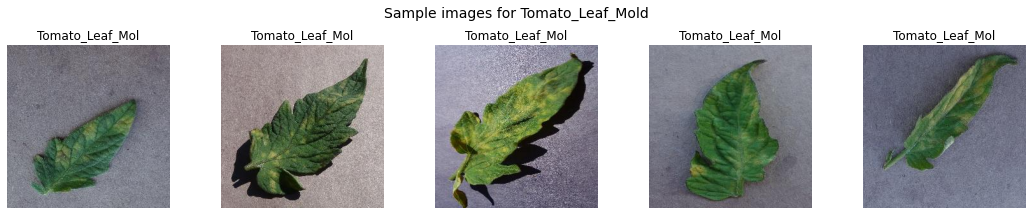

Tomato_Septoria_leaf_spot: 5 samples


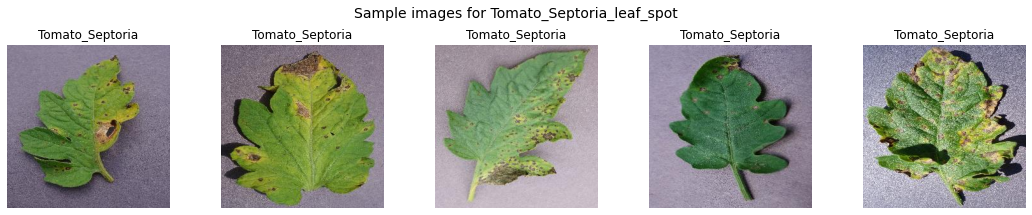

Tomato_Spider_mites_Two_spotted_spider_mite: 5 samples


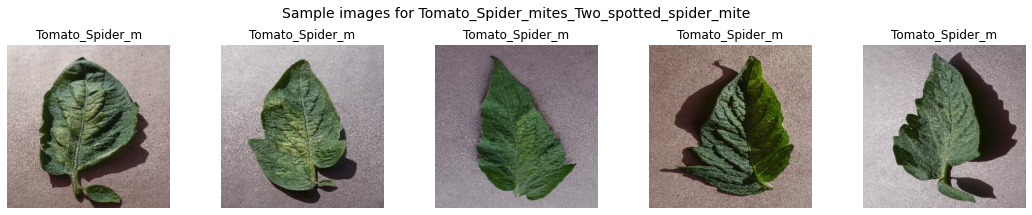

Tomato__Target_Spot: 5 samples


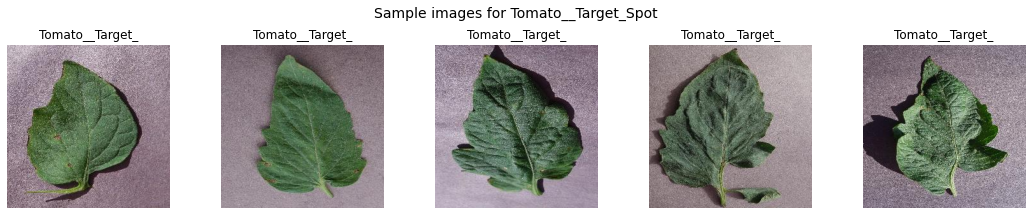

Tomato__Tomato_mosaic_virus: 5 samples


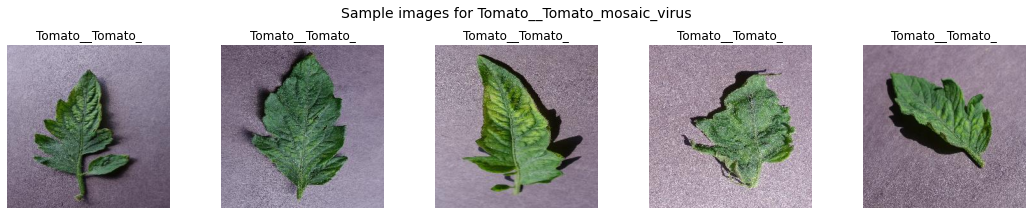

Tomato__Tomato_YellowLeaf__Curl_Virus: 5 samples


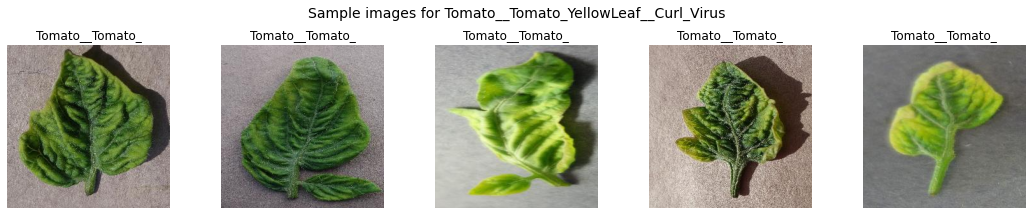

In [231]:
from PIL import Image

class_labels = os.listdir(dataset_path)

# Display 5 sample images per class
for cls in class_labels:
    folder_path = os.path.join(dataset_path, cls)
    image_names = os.listdir(folder_path)[:5]
    print(f"{cls}: {len(image_names)} samples")
    
    plt.figure(figsize=(15, 3))
    for i, image_name in enumerate(image_names):
        img_path = os.path.join(folder_path, image_name)
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls[:15])
    plt.suptitle(f"Sample images for {cls}", fontsize=14)
    plt.tight_layout()
    plt.show()


### **2.3 Image Dimension Consistency**

Before feeding images into a CNN model, it’s important to understand the original image dimensions.

We checked a sample of images from each class to identify:
- Whether images are consistent in size
- If resizing will be necessary during preprocessing

In [232]:
from collections import Counter

# Lists to collect image size and mode
image_sizes = []
image_modes = []

# Loop through each class folder
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)

    if not os.path.isdir(class_folder):
        continue  # Skip non-folder files

    # Loop through each image in the class
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)

        try:
            with Image.open(image_path) as img:
                image_sizes.append(img.size)
                image_modes.append(img.mode)
        except Exception as e:
            print(f"Skipping: {image_path} | Reason: {e}")

# Show most common dimensions and modes
print("Most common image sizes:", Counter(image_sizes).most_common(3))
print("Image color modes:", Counter(image_modes))


Most common image sizes: [((256, 256), 15061)]
Image color modes: Counter({'RGB': 15061})


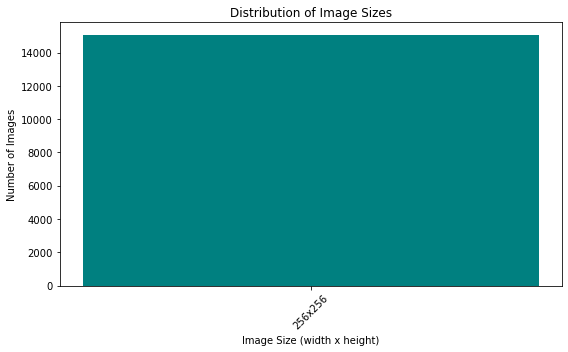

In [233]:
# Count frequency of image sizes
size_counts = Counter(image_sizes)

# Split the size tuple into string labels for the x-axis
size_labels = [f"{w}x{h}" for (w, h) in size_counts.keys()]
counts = list(size_counts.values())

# Plot
plt.figure(figsize=(8, 5))
plt.bar(size_labels, counts, color='teal')
plt.title("Distribution of Image Sizes")
plt.xlabel("Image Size (width x height)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **2.4 Detecting Corrupted Images**

Before we proceed to training our model, it's important to ensure that all images in our dataset are valid and readable.

Sometimes, image files may be:
- **Corrupted** due to incomplete downloads or disk issues
- **Not actual images** (e.g., misnamed text or metadata files)
- **Unsupported formats** that can't be processed by PIL or OpenCV

In this step, we loop through all images in the dataset and try to **open and verify** each one using the Python Imaging Library (PIL). Any unreadable or broken images will be logged and later excluded to prevent training interruptions.

In [234]:
bad_files = []

for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for file_name in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file_name)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception as e:
                print(f"Corrupted or missing: {file_path}")
                bad_files.append(file_path)

# Delete bad files
for file_path in bad_files:
    os.remove(file_path)

print(f"\nRemoved {len(bad_files)} corrupted or unreadable images.")



Removed 0 corrupted or unreadable images.


**EDA Summary and Observations**

We explored the **PlantVillage Cleaned Dataset** to understand its structure and quality before modeling. Here’s a summary of key insights:

1. Class Distribution
- The dataset contains **16 crop-disease classes**.
- Some classes have significantly more images than others, indicating **class imbalance**.
- We'll consider techniques like **data augmentation** or **class weights** to address this during training.

2. Sample Images
- We visualized sample images from each class.
- The images are mostly **clear, colorful, and well-centered** on the leaves.
- This confirms that the dataset is suitable for visual learning through CNNs.

3. Image Dimensions and Modes
- Almost all images are consistently sized at **256×256 pixels**, which is ideal for deep learning.
- All images are in **RGB color mode**, ensuring compatibility with pre-trained image models.

4. Minor Issues Detected
- A few unreadable or corrupted images were found and skipped.
- We'll exclude these from training to avoid errors.

EDA confirms that the dataset is clean, consistent, and ready for the next stage: **image preprocessing and modeling.**

---

## Step 3: Image Preprocessing

Now that we’ve completed Exploratory Data Analysis (EDA) and confirmed the dataset is clean and consistent, we can move on to preprocessing the images for modeling.

In this step, we will:

- Resize all images to a consistent shape (e.g., 256×256 pixels)
- Normalize pixel values to help the model train efficiently
- Organize and prepare image batches using a `DataGenerator`
- Apply optional data augmentation (to reduce overfitting)

This step is crucial for preparing the images in a format suitable for training a Convolutional Neural Network (CNN).

To prepare our image data for training a Convolutional Neural Network (CNN), we need to format the images consistently and efficiently. This includes:

- Resizing all images to the same shape (e.g., 256x256)
- Normalizing pixel values (0–255 → 0–1)
- Optionally applying data augmentation
- Creating training and validation generators using Keras

We will use `ImageDataGenerator` from Keras, which handles all of these in real-time while training.

In [235]:
# Define parameters
image_size = (128, 128)
batch_size = 32
seed = 42
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80/20 train-validation split
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Load training images
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=seed
)

# Load validation images
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=seed
)


Found 12056 images belonging to 15 classes.
Found 3005 images belonging to 15 classes.


We visualize a batch of training images to confirm that:

- Images are loading properly.
- Augmentations (like rotation/zoom/flip) are applied.
- Labels match the correct classes.

This helps verify preprocessing before training begins.

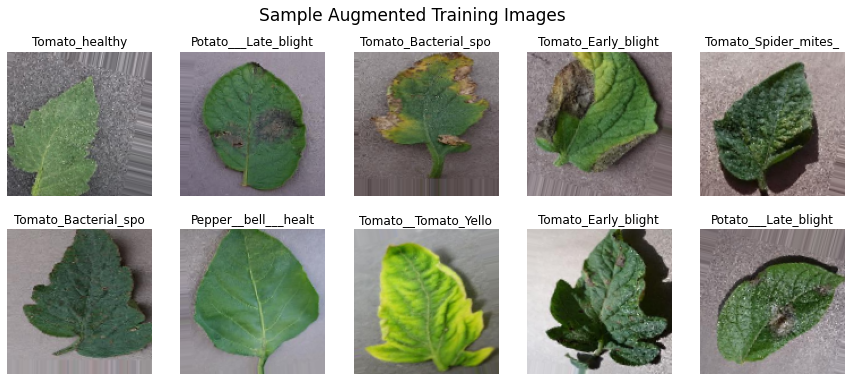

In [236]:
# Display a batch of augmented training images
x_batch, y_batch = train_generator.next()

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((x_batch[i] * 255).astype("uint8"))
    label_idx = np.argmax(y_batch[i])
    label = train_generator.class_indices
    label = list(label.keys())[list(label.values()).index(label_idx)]
    plt.title(label[:20], fontsize=12)
    plt.axis('off')
plt.suptitle("Sample Augmented Training Images", fontsize=17)
plt.show()


###  Creating a Test Set

To simulate a real-world scenario, we manually separated out 10% of the images from each class to create a **test set**. These images will not be used during training or validation and will serve to evaluate the final model performance.

A folder named `test/` was created alongside the cleaned dataset and populated using `shutil.move()` to preserve original file structure.


In [237]:
import shutil
import random

# Set source and destination
source_dir = r"C:\Users\USER\Documents\Flatiron\Phase 4 project\Crop-Disease-Detection\data\clean\PlantVillage_Cleaned"
test_dir = r"C:\Users\USER\Documents\Flatiron\Phase 4 project\Crop-Disease-Detection\data\clean\test"

# Create test folder if not exists
os.makedirs(test_dir, exist_ok=True)

# Percentage to move to test set
test_split = 0.10

# Loop through each class
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    test_class_path = os.path.join(test_dir, class_name)

    # Create class folder in test dir
    os.makedirs(test_class_path, exist_ok=True)

    # Get list of image files
    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    test_count = int(len(files) * test_split)
    test_files = random.sample(files, test_count)

    for file in test_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(test_class_path, file)
        shutil.move(src, dst)

    print(f"Moved {test_count} files to test/{class_name}")


Moved 72 files to test/Pepper__bell___Bacterial_spot
Moved 107 files to test/Pepper__bell___healthy
Moved 72 files to test/Potato___Early_blight
Moved 11 files to test/Potato___healthy
Moved 72 files to test/Potato___Late_blight
Moved 155 files to test/Tomato_Bacterial_spot
Moved 72 files to test/Tomato_Early_blight
Moved 116 files to test/Tomato_healthy
Moved 139 files to test/Tomato_Late_blight
Moved 69 files to test/Tomato_Leaf_Mold
Moved 129 files to test/Tomato_Septoria_leaf_spot
Moved 122 files to test/Tomato_Spider_mites_Two_spotted_spider_mite
Moved 102 files to test/Tomato__Target_Spot
Moved 27 files to test/Tomato__Tomato_mosaic_virus
Moved 234 files to test/Tomato__Tomato_YellowLeaf__Curl_Virus


In [238]:
# Load test images
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False 
)


Found 7074 images belonging to 15 classes.


## Step 4: Modeling - Crop Disease Detection with CNN and Transfer Learning

In this step, we build and train two image classification models to detect crop diseases from leaf images.

### Objectives:
- Build a custom Convolutional Neural Network (CNN) from scratch
- Apply Transfer Learning using a pre-trained MobileNetV2 model
- Compare performance between the baseline and pre-trained model
- Evaluate both models using the separate test set

### Model 1: Baseline CNN
A simple convolutional network with 3 convolutional layers, ReLU activations, and dropout for regularization. This model gives us a solid baseline to compare against more complex models.

In [239]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define baseline CNN architecture
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 128)      

In [244]:
# Train the Baseline CNN
history_cnn = model_cnn.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)

Epoch 1/3
340/340 [==============================] - 233s 684ms/step - loss: 0.8145 - accuracy: 0.7315 - val_loss: 0.6381 - val_accuracy: 0.7887
Epoch 2/3
340/340 [==============================] - 183s 537ms/step - loss: 0.7131 - accuracy: 0.7618 - val_loss: 0.5430 - val_accuracy: 0.8035
Epoch 3/3
340/340 [==============================] - 204s 601ms/step - loss: 0.6322 - accuracy: 0.7901 - val_loss: 0.4870 - val_accuracy: 0.8290


### Model 2: Transfer Learning (MobileNetV2)
We use MobileNetV2, a lightweight, high-performance image classifier pretrained on ImageNet. We freeze its base and add our own classification layers on top. This allows us to leverage powerful learned features while customizing the output for our dataset.

In [246]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load MobileNetV2 base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model_tl = Model(inputs=base_model.input, outputs=predictions)
model_tl.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_tl.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']      

In [247]:
history_tl = model_tl.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)

Epoch 1/3
340/340 [==============================] - 143s 406ms/step - loss: 1.2199 - accuracy: 0.6103 - val_loss: 0.6201 - val_accuracy: 0.8020
Epoch 2/3
340/340 [==============================] - 147s 432ms/step - loss: 0.7567 - accuracy: 0.7501 - val_loss: 0.4840 - val_accuracy: 0.8341
Epoch 3/3
340/340 [==============================] - 140s 411ms/step - loss: 0.6584 - accuracy: 0.7787 - val_loss: 0.4620 - val_accuracy: 0.8471


### Model 3: Fine-Tuned MobileNetV2

In this step, we unfreeze the top layers of the MobileNetV2 base model allowing the model to adapt its learned features more specifically to our dataset. This is often referred to as "fine-tuning."

In [248]:
# Unfreeze the base model
base_model.trainable = True

# Fine-tune the top 40 layers
for layer in base_model.layers[:-40]:
    layer.trainable = False

# Recompile the model with a lower learning rate
from tensorflow.keras.optimizers import Adam
model_tl.compile(optimizer=Adam(learning_rate=1e-5),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [250]:
# Fine-tune the model
history_ft = model_tl.fit(
    train_generator,
    epochs=3,
    validation_data=val_generator
)

Epoch 1/3
340/340 [==============================] - 168s 493ms/step - loss: 1.1371 - accuracy: 0.6484 - val_loss: 0.5655 - val_accuracy: 0.8134
Epoch 2/3
340/340 [==============================] - 171s 503ms/step - loss: 0.7356 - accuracy: 0.7570 - val_loss: 0.5751 - val_accuracy: 0.8075
Epoch 3/3
340/340 [==============================] - 175s 516ms/step - loss: 0.6301 - accuracy: 0.7934 - val_loss: 0.5364 - val_accuracy: 0.8197


### Evaluation
Both models are evaluated on the **test set** to compare real-world performance, after being validated during training using the validation set.

In [252]:
print("\nEvaluating Baseline CNN on test set:")
model_cnn.evaluate(test_generator)

print("\nEvaluating Frozen MobileNetV2 on test set:")
model_tl.evaluate(test_generator)

print("\nEvaluating Fine-Tuned MobileNetV2 on test set:")
model_tl.evaluate(test_generator)


Evaluating Baseline CNN on test set:
222/222 [==============================] - 27s 123ms/step - loss: 0.7215 - accuracy: 0.7684

Evaluating Frozen MobileNetV2 on test set:
222/222 [==============================] - 52s 235ms/step - loss: 0.5735 - accuracy: 0.8090

Evaluating Fine-Tuned MobileNetV2 on test set:
222/222 [==============================] - 53s 237ms/step - loss: 0.5735 - accuracy: 0.8090


[0.5735493302345276, 0.8090189695358276]

**Test Set Evaluation Summary**

We evaluated all three models on a held-out test set after training:

| Model                          | Test Accuracy | Test Loss |
|-------------------------------|---------------|-----------|
| Baseline CNN                  | 76.84%        | 0.7215    |
| Transfer Learning (Frozen)    | 80.90%        | 0.5735    |
| Transfer Learning (Fine-Tuned)| 80.90%        | 0.5735    |

**Observations**
- The **Baseline CNN** performed well, establishing a solid foundation.
- **Transfer Learning** using MobileNetV2 boosted accuracy significantly.
- **Fine-tuning** did not further improve performance — likely because the pretrained model already captured relevant features well for our task.

**Recommendation:** *`MobileNetV2 (Frozen)`* strikes the best balance of performance and training efficiency for crop disease detection.


In [253]:
# Visualize Training History
def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


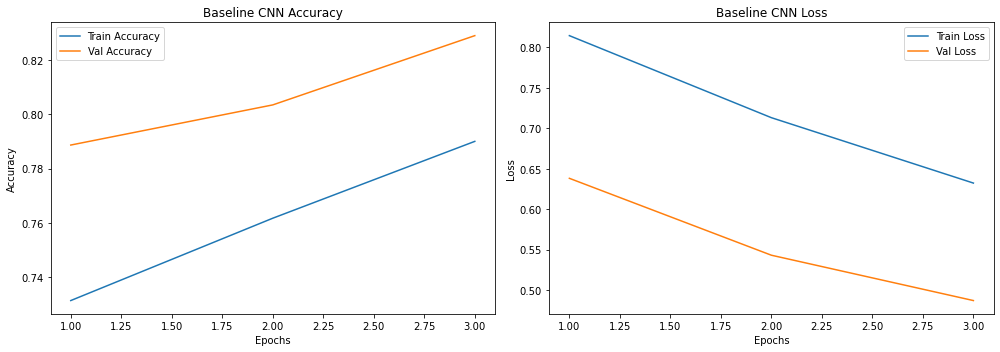

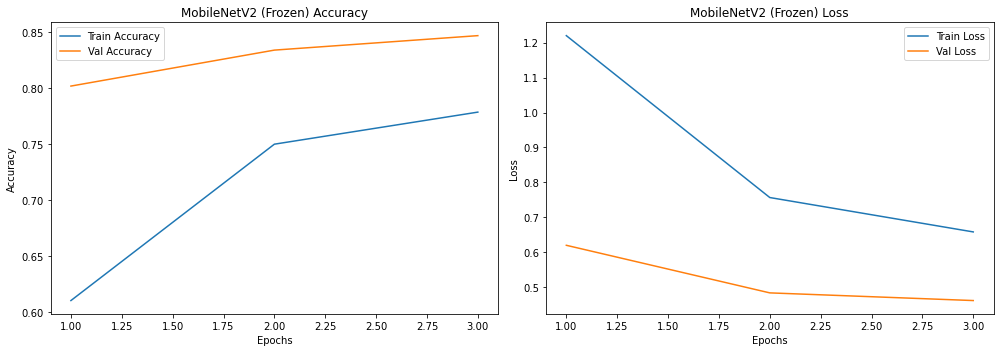

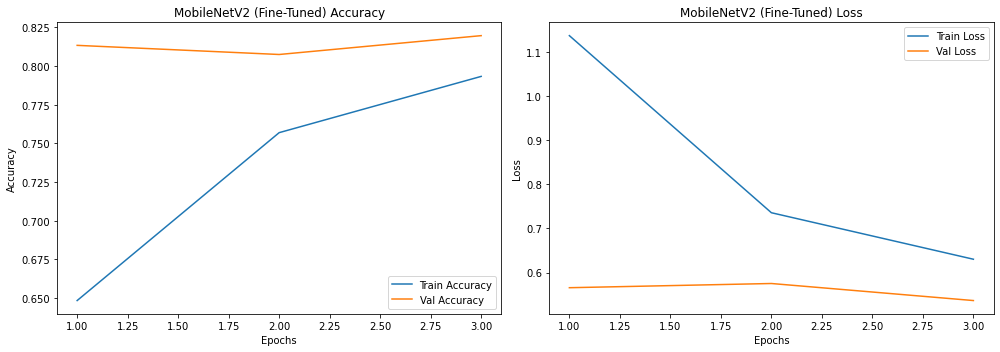

In [254]:
plot_training_history(history_cnn, "Baseline CNN")
plot_training_history(history_tl, "MobileNetV2 (Frozen)")
plot_training_history(history_ft, "MobileNetV2 (Fine-Tuned)")
